# Stock Picking 
## Group 1 ML Part II Coursework


Stock picking has been a long practice in the market where mutual funds have clamied they can beat the market. The claim has been debated since the Princeton professor Burton Malkiel said expert's stock picks peform as well as blind monkeys throwing darts. Some have even demonstrated the monkey even did a better job than the experts.

https://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#24c34e92630a

Here we try to use Machine Learning classifier to beat the monkey's performance. Since it is illegal to own one, we simulate the monkey by a random picking algo. 

In [32]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.model_selection import train_test_split


First we structure the data. We collected stocks listed on NYSE and NASDAQ fundamental financial ratios of Q4 2017 as features(X) as well as price information of Q4 2017-18 from Bloomberg. We drop the Nan when Bloomberg has no avilable data. Bloomberg is the lead market participant in financial data provider. If they don't have the information, doubt other data vendor (FACTSET, Reuters) has it. We split the data by the function that exists in sklearn. The reason behind it is that the function probably handles splitting the data a lot better than we would have and it is better practice to not re-write and use already existing code.

In [14]:
df = pd.read_csv("./resources/2018.csv")
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,Symbol,cash_ratio,return_to_equity,price_to_book,pe,short_interest_ratio,debt_to_equity,eps,last_price,previous_year_price,NYSE_NASDAQ
0,MMM,0.4571,37.66730402,10.519554,25.3366,2.959,142.6619,1.01,199.15,236.58,0
1,WUBA,0.9377,7.842562916,3.466236,247.7696,1.584,4.1318,1.18,69.68,68.93,0
2,EGHT,4.0372,-41.19122937,7.989302,31.7871,2.115,0.0000,-0.14,19.775,14.10,0
3,AHC,1.6529,12.38072109,1.109514,971.1333,1.213,0.0000,-0.19,4.75,4.85,0
4,AAC,0.3138,-12.45305726,1.540616,12.3618,14.426,193.2304,-0.01,9.86,9.11,0


Picking the financial ratios was part of the feature engineering that we had to do for this project. As one might know, there are a number of financial ratios that can describe the fundamental state of company. They usually contain information about the health/growth/profitability of the company, which are all important factors for the company and if an investor feels it is good enough to invest in.

We chose the ratios based on the 2 following factors:
    1) Popularity (among investors)
    2) Availability from our data source (Bloomberg)
    
As far as 1) goes, the ratios we picked were favourites among fundamental investors. They have been known to be used for fundamental analysis for many years and seem to describe a company and it's future performance well. There are a number of other factors/ratios that we wanted to use, to further the analysis, however our data vendor either kept running out of data, or there was not enought coverage of those ratios for the companies we selected.

### Label Outperforming and Underperfoming the market 
The market return is defined as the 1 year log return of the market. Stock is labelled "outperform" or "1" when its 1 year log return is bigger than its respective market return(NYSE or NASDAQ). Stock is labelled "underperform" or "0" vice versa.

In [15]:
nyse_previous_close = 12412.07
nyse_one_year_close = 11812.20

nasdaq_previous_close = 7712.9502
nasdaq_one_year_close = 6233.9502

nasdaq_begin_index = 977

nyse_performance = math.log(nyse_previous_close/nyse_one_year_close)
nasdaq_performance = math.log(nasdaq_previous_close/nasdaq_one_year_close)

# print(nyse_performance)

df = df.infer_objects()
df['last_price'] = df['last_price'].astype('float')

#print(df.dtypes)

df['performance'] = np.log(df['last_price'] /df['previous_year_price'])
df['status'] = 0
nyse_performance = (df.loc[range(0,nasdaq_begin_index),'performance']>nyse_performance).astype('int')
nasdaq_performance = (df.loc[range(nasdaq_begin_index,len(df)),'performance']>nasdaq_performance).astype('int')
df['status'] = nyse_performance
df.loc[nasdaq_begin_index:len(df),'status'] = nasdaq_performance
df['status'] = df['status'].astype('int')


Here the data is normalized. The normalization in this case occurs because the range of values varies a lot. However, since we are going to be calculating distances between values, we would like to scale our variables.

In [16]:
def normalize_data(x,min,max):
    return (x-min)/(max-min)

In [17]:
#normalize data
df[['cash_ratio','return_to_equity','price_to_book','pe','short_interest_ratio','debt_to_equity','eps']] = normalize(df[['cash_ratio','return_to_equity','price_to_book','pe','short_interest_ratio','debt_to_equity','eps']],axis=0, norm='max')
df.dropna()     # need to dropnan else can't model


cr = normalize_data(df['cash_ratio'],min(df['cash_ratio']),max(df['cash_ratio']))

### Alex change here K-fold for spiltting data 
K-fold is performed to split the dataset into train, val and test. Integer 1 to 10 is uniform randomly assigned to each stock. Stocks with "fold" number less or equal to 6.5 is splitted to the train data set. Stocks with "fold" number bigger than 6.5  and less or equal to 9 is splitted to the validation data set. The rest is splitted to the test data set. We drop Nan again to make sure there are no missing data. 

In [18]:
# set random seed for folding
np.random.seed(2018)
df['fold'] = np.random.uniform(1,10,len(df))

id_train = np.where(df['fold']<=6.5)[0]
id_val = np.intersect1d(np.where(df['fold'] > 6.5)[0],np.where(df['fold'] <= 9)[0])
id_test = np.where(df['fold']>9)[0]

n_train = len(id_train)
n_val = len(id_val)
n_test = len(id_test)



X = df[['cash_ratio','return_to_equity','price_to_book',
        'pe','short_interest_ratio','debt_to_equity','eps',
        'NYSE_NASDAQ']]
y = df['status']


## Prepare train data set, droping Nan
X_train = X.iloc[id_train]
X_train = X_train.dropna()


y_train = y.iloc[id_train]
y_train = y_train.dropna()



## Prepare validation data set
X_val = X.iloc[id_val]
X_val = X_val.dropna()


y_val_true = y.iloc[id_val]
y_val_true = y_val_true.dropna()



## Prepare test data set, droping Nan
X_test = X.iloc[id_test]
X_test = X_test.dropna()

y_test_true = y.iloc[id_test]
y_test_true = y_test_true.dropna()


Since the data is not sequential/ time-series, there is no need of forward chaining. However the release of the financial ratios might not matches the return (whether the stock return outperform/ underperform the market) info at the exact same date. It is very difficult to pinpoint a date where all price info and financial ratios are available. We accept the shortcoming and proceed. 

## Performance Metrics
Assuming we are "the experts" of a long only fund. We would like to minimise our number of bad choices and maximise our number of good choices, "False Positive" and "True Positive" (since we don't short underperforming stocks). We uses precision as our performance metric. 

$Precision = \frac{True \ Positive}{True  \ Positive \ + \ False \ Positive}$

In addition, we calculate the confusion matrix for each model:  
    $ \ A  = \begin{pmatrix} 
True \ Negative & False \ Positive \\
False  \ Negative & True \ Positive
\end{pmatrix}$

In [19]:
def confusion_matrix_for_reg(predict, real):
    
    ## when running regression, we expect the predict performance would not consists only 1 or 0. 
    ## We round the predicted performance to the first decimal
    predict = np.array(np.round(predict))
    
    ## We also limit the prediction between 0 and 1
    predict = predict.clip(min=0, max=1)
    
    real = np.array(real)


    ## use AND gate to check for TP
    TP = np.sum(np.logical_and(predict, real))
    ## sum of all 1s in predict - TP = FP
    FP = np.sum(predict ==1) - TP


    ## first flip predict and real 1 and 0s, and use the same AND gate to check for TN
    TN = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(real)))
    FN = np.sum(predict ==0) - TN



    conf_matrix = [[TN, FP], [FN, TP]]


    return conf_matrix

### Monkey stock picking
We simulate the monkey stock picking by randomly choosing under or overperform for each stock. This is our first naive method as stocks are simply picked by random, diregarding their fundamental financial ratios.


In [20]:
np.random.seed(2018)
y_train_from_random = np.random.uniform(1,0,len(y_train))

y_test_from_random = np.random.uniform(1,0,len(y_test_true))

### OLS regression 
One of the textbook methods of fundamental analysis is a simple OLS regression(fundamental model) to model stock performance. OLS can be seen as our second naive method as we assume there the relationships between features and the stock performance are linear. The loss function to be minimised is

$arg \ min_{\beta} ||y - X  \ \beta \ ||_{2}^2$

y is the labelled data, 1 and 0 representing performance in our case. X represents the matrix of features with $\beta$ as the regression coefficients. 

The first model is fitted with the train data set to predict train performance. The second model is first fitted with validation data set and used to predict the test performance. 

In [21]:
def model_OLS(data_X_train, data_y_train, data_X_val, data_y_val_true, data_X_test):
    linreg = linear_model.LinearRegression(fit_intercept=True)  # can change with or without intercept
    linreg.fit(data_X_train, data_y_train)
    linreg.get_params()
    y_train_from_OLS = linreg.predict(data_X_train)

    linreg.fit(data_X_val,data_y_val_true)
    linreg.get_params()
    y_test_from_OLS = linreg.predict(data_X_test)
    return y_train_from_OLS, y_test_from_OLS

### LASSO regression
The LASSO regression is a penalised regression where 

$arg \ min_{\beta} ||y - X  \ \beta \ ||_{2}^2 + \lambda \ || \beta ||_1$

is the loss function to be minimised. The first term is to reduce bias and the second term is to reduce varaince. $\lambda$ is the penalised coefficient for increased complexity. 

In [22]:
def model_Lassi(data_X_train, data_y_train, a, data_X_val):
    Lassi = Lasso(alpha=a, tol=1e-5)
    Lassi.fit(data_X_train, data_y_train)
    y_train_from_LASSO = Lassi.predict(data_X_train)

    y_val_from_LASSO = Lassi.predict(data_X_val)

    return y_train_from_LASSO, y_val_from_LASSO

### Ridge regression

The Ridge regression is a penalised regression where 

$arg \ min_{\beta} ||y - X  \ \beta \ ||_{2}^2 + \lambda \ || \beta ||^2_{2}$

is to be minimised. The difference between LASSO and Ridge is the penality term for complexity is squared insetad of absoluted in Ridge. LASSO's regularisation is L1 instead of L2 regularisation in Ridge. This allows LASSO to shrinks the irrelevant features to zero. 

In [23]:
def model_Rachel(data_X_train, data_y_train, a, data_X_val):
    Rachel = Ridge(alpha=a, tol=1e-5)
    Rachel.fit(data_X_train, data_y_train)
    y_train_from_Ridge = Rachel.predict(data_X_train)

    y_val_from_Ridge = Rachel.predict(data_X_val)

    return y_train_from_Ridge, y_val_from_Ridge

### Run OLS regression

In [24]:
y_train_from_OLS, y_test_from_OLS = model_OLS(X_train, y_train, X_val, y_val_true, X_test)

conf_matrix_train_from_OLS = confusion_matrix_for_reg(y_train_from_OLS, y_train)

conf_matrix_test_from_OLS = confusion_matrix_for_reg(y_test_from_OLS, y_test_true)

### Optimising lambda for the penalised regression models
The amount of penality with increased compexity is adjusted by $\lambda$. The optimal $\lambda$ is chose based on the the precision using a for loop fitting the validation data set.

In [25]:
## TODO Optimizing LASSO and Ridge Lambda

## initialising

# range of lambda we are testing
x_axis_interval = np.arange(0,0.7, 1e-3)

# list of confusion matrix and precision
conf_matrix_train_from_LASSO = []
prec_train_LASSO =[]

conf_matrix_val_from_LASSO = []
prec_val_LASSO =[]

conf_matrix_train_from_Ridge = []
prec_train_Ridge =[]

conf_matrix_val_from_Ridge =[]
prec_val_Ridge = []


## finding optimal lambda for the least amount of False Positive
for a in x_axis_interval:

    y_train_from_LASSO, y_val_from_LASSO = model_Lassi(X_train, y_train, a, X_val)
    
    ## calculate the confusion matrix
    conf_matrix_train_from_LASSO.append(confusion_matrix_for_reg(y_train_from_LASSO, y_train))
    
    ## calculating the precision by TP/ (TP + FP)
    prec_train_LASSO.append(confusion_matrix_for_reg(y_train_from_LASSO, y_train)[1][1] /
                            (confusion_matrix_for_reg(y_train_from_LASSO, y_train)[1][1] +
                             confusion_matrix_for_reg(y_train_from_LASSO, y_train)[0][1]))


    conf_matrix_val_from_LASSO.append(confusion_matrix_for_reg(y_val_from_LASSO, y_val_true))
    prec_val_LASSO.append(confusion_matrix_for_reg(y_val_from_LASSO, y_val_true)[1][1] /
                          (confusion_matrix_for_reg(y_val_from_LASSO, y_val_true)[1][1] +
                           confusion_matrix_for_reg(y_val_from_LASSO, y_val_true)[0][1]))

    y_train_from_Ridge, y_val_from_Ridge = model_Rachel(X_train, y_train, a, X_val)

    conf_matrix_train_from_Ridge.append(confusion_matrix_for_reg(y_train_from_Ridge, y_train))
    
    prec_train_Ridge.append(confusion_matrix_for_reg(y_train_from_Ridge, y_train)[1][1] /
                            (confusion_matrix_for_reg(y_train_from_Ridge, y_train)[1][1] +
                             confusion_matrix_for_reg(y_train_from_Ridge, y_train)[0][1]))

    conf_matrix_val_from_Ridge.append(confusion_matrix_for_reg(y_val_from_Ridge, y_val_true))
    
    prec_val_Ridge.append(confusion_matrix_for_reg(y_val_from_Ridge, y_val_true)[1][1] /
                          (confusion_matrix_for_reg(y_train_from_Ridge, y_train)[1][1] +
                           confusion_matrix_for_reg(y_train_from_Ridge, y_train)[0][1]))

print(prec_val_Ridge)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in long_scalars


[0.2857142857142857, 0.3333333333333333, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

### Precision across lambdas

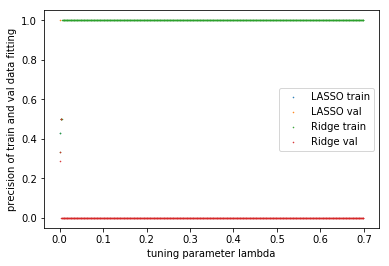

In [26]:
# Plotting the precisions across lambdas
plt.scatter(x_axis_interval,prec_train_LASSO, label="LASSO train", s=0.3)
plt.scatter(x_axis_interval, prec_val_LASSO, label="LASSO val", s=0.3)
plt.scatter(x_axis_interval,prec_train_Ridge, label="Ridge train", s=0.3)
plt.scatter(x_axis_interval,prec_val_Ridge, label="Ridge val", s=0.3)

plt.xlabel('tuning parameter lambda')
plt.ylabel('precision of train and val data fitting')
plt.legend()
plt.show()

### Optimal model with optimal lambda for predicting from test data set
We chose the optimal $\lambda$ according to the precisison of the model. We retrain the model with the validation data set and the optimal $\lambda$ to predict using test data.

In [27]:
a_range = x_axis_interval

## Only optimize for minimum FP, long only fund
opt_lambda_LASSO = a_range[prec_val_LASSO.index(max(prec_val_LASSO))]
opt_lambda_Ridge = a_range[prec_val_Ridge.index(max(prec_val_Ridge))]

## predicting test data set with optimal lambda/ alpha, returning confusion matrix

Lassi_opt = Lasso(alpha=opt_lambda_LASSO, tol=1e-5)
Lassi_opt.fit(X_val, y_val_true)
y_test_from_Lassi = Lassi_opt.predict(X_test)

conf_matrix_test_Lassi = confusion_matrix_for_reg(y_test_from_Lassi,y_test_true)


Rachel_opt = Ridge(alpha=opt_lambda_Ridge, tol=1e-5)
Rachel_opt.fit(X_val, y_val_true)
y_test_from_Rachel = Rachel_opt.predict(X_test)

conf_matrix_test_Rachel = confusion_matrix_for_reg(y_test_from_Rachel, y_test_true)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [28]:
print("optimal lambda/ tuning parameters for LASSO:", opt_lambda_LASSO,"\n","optimal lambda/ tuning parameters for Ridge:", opt_lambda_Ridge)


print("OLS's confusion matrix of training:", conf_matrix_train_from_OLS,"\n",
      "OLS's confusion matrix of testing:", conf_matrix_test_from_OLS,"\n",
      "LASSO's confusion matrix of testing", conf_matrix_test_Lassi,"\n",
      "Ridge's confusion matrix of testing", conf_matrix_test_Rachel)


## TODO Performance metric, calculating precision

## first get confusion matrix of randomly picking

conf_matrix_train_from_random = confusion_matrix_for_reg(y_train_from_random, y_train)
conf_matrix_test_from_random = confusion_matrix_for_reg(y_test_from_random, y_test_true)

conf_matrix_list = [conf_matrix_train_from_random, conf_matrix_test_from_random,
                    conf_matrix_train_from_OLS, conf_matrix_test_from_OLS,
                    conf_matrix_test_Lassi, conf_matrix_test_Rachel]


prec_list = []

for i in conf_matrix_list:
    prec_list.append(float(i[1][1])/ float(i[0][1] + i[1][1]))
print("train_from_random", "test_from_random",
                    "train_from_OLS", "test_from_OLS",
                    "test_LASSO", "test_Ridge")
print(prec_list)

optimal lambda/ tuning parameters for LASSO: 0.0 
 optimal lambda/ tuning parameters for Ridge: 0.002
OLS's confusion matrix of training: [[650, 4], [446, 3]] 
 OLS's confusion matrix of testing: [[121, 6], [83, 7]] 
 LASSO's confusion matrix of testing [[121, 6], [83, 7]] 
 Ridge's confusion matrix of testing [[123, 4], [87, 3]]
train_from_random test_from_random train_from_OLS test_from_OLS test_LASSO test_Ridge
[0.4177215189873418, 0.4215686274509804, 0.42857142857142855, 0.5384615384615384, 0.5384615384615384, 0.42857142857142855]


It seems the optimal lambda is exactly 0 for LASSO and almost 0 for Ridge regression, converging back to an OLS regression. Indicating there is no advantage to increase the model complexity.

# SVM: Support Vector Machine

The SVM is a machine learning technique most often utilized for classification. The goal of the learning technique is to draw a hyperplane(in linear 2D SVM that is a line) between data that is distinctly classified in different categories. The best choice will be the hyperplane that leaves the maximum margin from both classes. The goal of the svm algorithm is to maximize the separability between the data points and the hyperplane.

Any hyperplane can be written as $w \cdot x - b = 0$, and having a binary classification of -1,1 yields the following 2 equations $w \cdot x - b = -1$ and $w \cdot x - b = 1$. Geometrically, the distance between these 2 lines (margin) is $\frac{2}{||w||}$. The job of the classifier is to minimize the fraction with the constraints of correct classification. More conretely, the minimization that needs to take place is $\min{w}||w||^2$ with the constraint of $y_i(w^Tx_i+b) >= 1$

In general, there is a trade off between the margin and the number of mistakes on the data i.e. the points can be linearly separated but there is a narrow margin or the margin solution is better even though some constraints might be violated. As a result, slack variables can be introduced ($\xi$), which would control the aforementioned effect. Thus we reach a "soft" margin solution where the optimization becomes $\min{w}||w||^2 + C\sum_{i}^{N}\xi_i$ subject to $y_i(w^Tx_i+b) >= 1-\xi_i$, where C is a regularization parameter.

Rewriting the the constraint $y_i(w^Tx_i+b) >= 1-\xi_i$ as $y_if(x_i)>=1-\xi_i$ and with $\xi_i>0$ we get $\xi_i=max(0,1-y_if(x_i)$, which makes our problem an uncostrainted optimization over w of the form: $\min||w||^2+C\sum_{i}^{N}\max(0,1-y_if(\xi_i))$ with the second part of the equation being the loss function.


Our problem is perfect for a SVM as it's main function is to classify companies as underperforming or overperforming. Minimizing the loss function would create a hyperplane that would distinguish between overperforming and underperforming companies. 

In terms of hyperparameters, scikitlearn svm has 2 main ones. The C and the gamma. Following https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, we set the range of the hyperparameters accordingly. Finally, since it is hard to visualize what our dataset would look like, we added another hyperparameter which was the kernel of the svm. We excluded the polynomial kernel, as it took a very long time to train and fit the data.

The metrics that were used for the data are similar to the regressions.



In [33]:
#variable to hold our hyper-parameter results.
results = pd.DataFrame(columns=['C','gamma','algo','test_precision','test_recall','train_precision','train_recall'],index=range(1000000))

df = df.dropna()
df = df.reset_index(drop=True)

## formatting the input and the expected output we get
X = df[['cash_ratio','return_to_equity','price_to_book','pe','short_interest_ratio','debt_to_equity','eps']]
y = df['status']

The following functions are defined in order to help with the production of the outputs of the SVM. Product metrics produces the confusion metrics via the built-in variable and the important metrics that were mentioned before (precision and recall)

The run model splits the dataset into train and validation set and trains the SVM model, as well as predicting using both the train and validation set. The function was created in order to use hyper-parametrization on the important variables.

In [34]:
def product_metrics(real, pred):
    #print("Non 0 results " + str(sum(pred != 0)) + " ,0 results " + str(sum(pred == 0)))
    C = confusion_matrix(real, pred)
    tn, fp, fn, tp = C[0, 0], C[0, 1], C[1, 0], C[1, 1];
    try:
        precision = float(tp) / float((tp + fp))
    except(ZeroDivisionError):
        precision = 0
    try:
        recall = float(tp) / float((tp + fn))
    except(ZeroDivisionError):
        recall = 0
    #print("Precision " + str(precision) + " Recall " + str(recall))
    return precision,recall

def run_model(C,gamma,algo):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, shuffle=True, stratify=y)
    clf = svm.SVC(kernel=algo,C=C,gamma=gamma)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    train_precision, train_recall = product_metrics(y_train, train_pred)
    test_precision, test_recall = product_metrics(y_test, test_pred)

    return C,gamma,algo,train_precision,train_recall,test_precision,test_recall


This specific piece of code takes a long time to run which is why the results are saved in a csv. The results are going to be uploaded for further examination. For a shorter run time, you can try the commented C's and gammas.

In [35]:
#gammas = [2**x for x in range(-10,10,2)]
#Cs = [2**x for x in range(-10,10,2)]
Cs = [10,100,1000]
gammas = [0.1,0.2,0.5,1.0]
algos = ['linear','rbf','sigmoid']

counter = 0
for algo in algos:
    for c in Cs:
        for gamma in gammas:
            results.iloc[counter] = run_model(c,gamma,algo)
            print(results.iloc[counter])
            counter = counter+1;

#results.to_csv('./resources/results.csv', sep=',')

C                          10
gamma                     0.1
algo                   linear
test_precision              1
test_recall        0.00325733
train_precision             0
train_recall                0
Name: 0, dtype: object
C                          10
gamma                     0.2
algo                   linear
test_precision              1
test_recall        0.00325733
train_precision             0
train_recall                0
Name: 1, dtype: object
C                          10
gamma                     0.5
algo                   linear
test_precision              1
test_recall        0.00325733
train_precision             0
train_recall                0
Name: 2, dtype: object
C                          10
gamma                       1
algo                   linear
test_precision              1
test_recall        0.00325733
train_precision             0
train_recall                0
Name: 3, dtype: object
C                         100
gamma                     0.1
algo    

Plotting hyper-parameterization variables.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


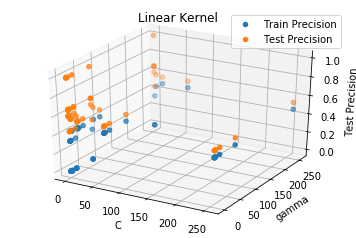

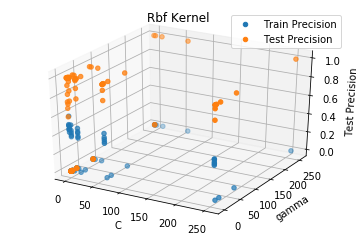

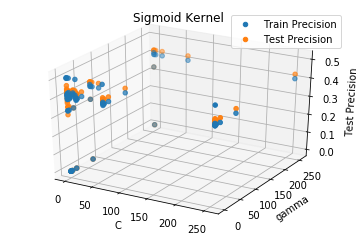

In [36]:
results = pd.read_csv("./resources/results.csv")

linear = results.iloc[np.where(results['algo']=='linear')]
rbf = results.iloc[np.where(results['algo']=='rbf')]
sigmoid = results.iloc[np.where(results['algo']=='sigmoid')]

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(linear['C'], linear['gamma'], linear['train_precision'], label='Train Precision')
ax.scatter(linear['C'], linear['gamma'], linear['test_precision'], label='Test Precision')
ax.legend()
ax.set_title("Linear Kernel")
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('Test Precision')

fig1 = plt.figure()
ax1 = fig1.gca(projection='3d')
ax1.scatter(rbf['C'], rbf['gamma'], rbf['train_precision'], label='Train Precision')
ax1.scatter(rbf['C'], rbf['gamma'], rbf['test_precision'], label='Test Precision')
ax1.legend()
ax1.set_title("Rbf Kernel")
ax1.set_xlabel('C')
ax1.set_ylabel('gamma')
ax1.set_zlabel('Test Precision')

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.scatter(sigmoid['C'], sigmoid['gamma'], sigmoid['train_precision'], label='Train Precision')
ax2.scatter (sigmoid['C'], sigmoid['gamma'], sigmoid['test_precision'], label='Test Precision')
ax2.legend()
ax2.set_title("Sigmoid Kernel")
ax2.set_xlabel('C')
ax2.set_ylabel('gamma')
ax2.set_zlabel('Test Precision')

plt.show()


The best results for each kernel are demonstrated below:

In [37]:
linear['f1_train'] = 2*((linear['train_precision']*linear['train_recall'])/(linear['train_precision']+linear['train_recall']))
linear['f1_test'] = 2*((linear['test_precision']*linear['test_recall'])/(linear['test_precision']+linear['test_recall']))

rbf['f1_train'] = 2*((rbf['train_precision']*rbf['train_recall'])/(rbf['train_precision']+rbf['train_recall']))
rbf['f1_test'] = 2*((rbf['test_precision']*rbf['test_recall'])/(rbf['test_precision']+rbf['test_recall']))

sigmoid['f1_train'] = 2*((sigmoid['train_precision']*sigmoid['train_recall'])/(sigmoid['train_precision']+sigmoid['train_recall']))
sigmoid['f1_test'] = 2*((sigmoid['test_precision']*sigmoid['test_recall'])/(sigmoid['test_precision']+sigmoid['test_recall']))

linear['f1'] = linear['f1_train']+linear['f1_test']
rbf['f1'] = rbf['f1_train']+rbf['f1_test']
sigmoid['f1'] = sigmoid['f1_train']+sigmoid['f1_test']

linear_best_f1 = linear.loc[linear['f1'].idxmax()]
rbf_best_f1 = rbf.loc[rbf['f1'].idxmax()]
sigmoid_best_f1 = sigmoid.loc[sigmoid['f1'].idxmax()]

print("BEST F1")
print("Linear------\n" +str(linear_best_f1))
print("Rbf------\n"+str(rbf_best_f1))
print("Sigmoid------\n"+str(sigmoid_best_f1))

BEST F1
Linear------
Unnamed: 0                  90
C                          256
gamma              0.000976562
algo                    linear
test_precision        0.537849
test_recall            0.21987
train_precision       0.464286
train_recall          0.254902
f1_train              0.329114
f1_test               0.312139
f1                    0.641253
Name: 90, dtype: object
Rbf------
Unnamed: 0              172
C                        16
gamma              0.015625
algo                    rbf
test_precision     0.986992
test_recall        0.988599
train_precision    0.452381
train_recall       0.372549
f1_train           0.408602
f1_test            0.987795
f1                   1.3964
Name: 172, dtype: object
Sigmoid------
Unnamed: 0                 260
C                            4
gamma              0.000976562
algo                   sigmoid
test_precision        0.439935
test_recall           0.441368
train_precision       0.507692
train_recall          0.431373
f1_train 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

It is clear that the rbf provides the best f1 overall score. This is not the case just for the best score out of the 3, but in general overall. It should be noted that the addition of the train and test f1 score is taken into account, as there exist f1 scores in the test set where the f1 score is 1.